In [1]:
from helpers.vae import VAE
from helpers.train import train_online, train

In [2]:
from helpers.train import train_online_alternately

In [3]:
from helpers.convert_to_var_foo import convert_to_var

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

### Создание данных

In [6]:
dim = 50
num_classes = 5

In [7]:
def get_one_hot_object(obj_class, dim, num_classes):
    x = np.zeros(dim)
    x[:(dim//num_classes) * (obj_class+1)] = 1
    return x

In [8]:
X_train = []
X_test = []
num_per_class = 250
for i in range(num_classes):
    X_test.append(get_one_hot_object(i, dim, num_classes))
    for j in range(num_per_class):
        X_train.append(get_one_hot_object(i,
                                          dim, num_classes))
X_train = np.array(X_train)
X_test = np.array(X_test)

### Обучение по батчам

In [7]:
model = VAE(input_shape=(-1, dim), n_samples=25)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

100%|██████████| 39/39 [00:07<00:00,  5.25it/s]


CPU times: user 6min 9s, sys: 2.74 s, total: 6min 12s
Wall time: 2min 55s


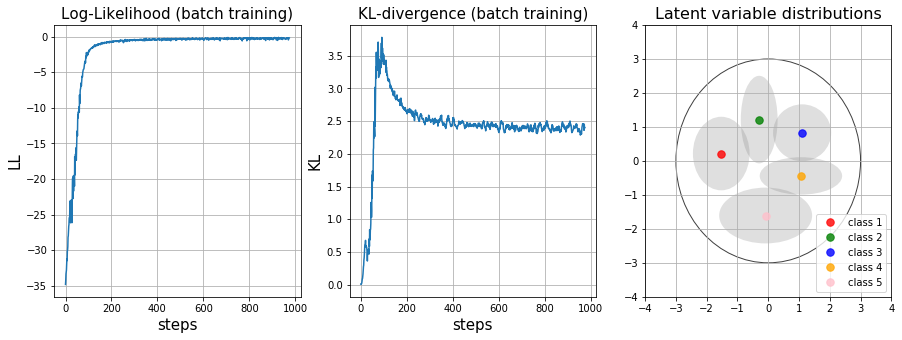

In [9]:
%%time
results = train(X_train, X_test, model, optimizer, num_epochs=25, batchsize=32, img_name=None)

In [12]:
ll_log, kld_log, pgs_log = results
ll_log = np.array(ll_log)

In [13]:
ll_log[-10:].mean()

-0.24769817441701888

### Обучение онлайн

#### стационарные данные

In [9]:
num_steps = 1000
np.random.seed(11)
schedule = [np.random.randint(num_classes) for i in range(num_steps)]

CPU times: user 1min 9s, sys: 256 ms, total: 1min 9s
Wall time: 25.1 s


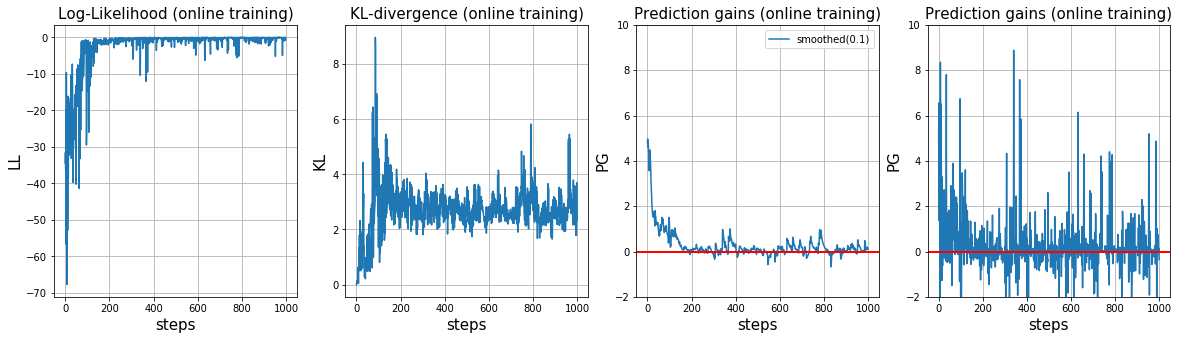

In [8]:
%%time
model = VAE(input_shape=(-1, dim), n_samples=25)
optimizer = optim.RMSprop(model.parameters(), lr=5*1e-5, momentum=0.9, eps=1e-4)
results = train_online(schedule, X_test,model, optimizer, kl_weight=1, img_name=None)

CPU times: user 1min 9s, sys: 340 ms, total: 1min 9s
Wall time: 25.1 s


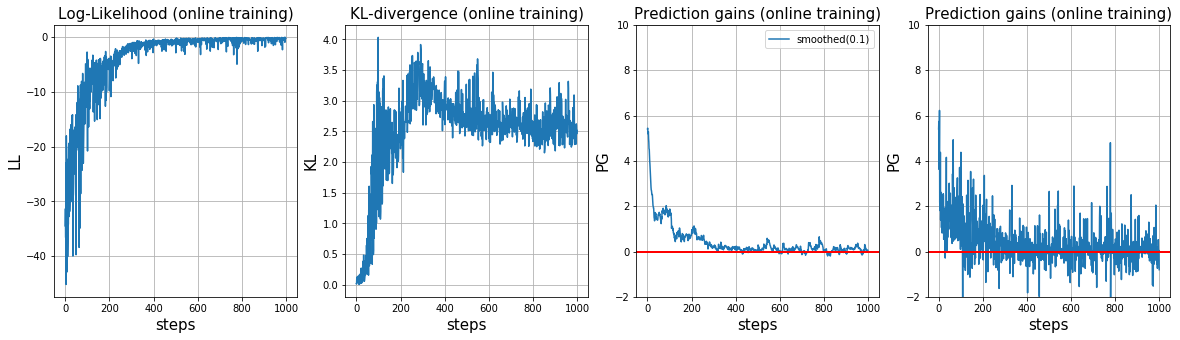

In [11]:
%%time
#Такие параметры сейчас в тексте
model = VAE(input_shape=(-1, dim), n_samples=25)
optimizer = optim.RMSprop(model.parameters(), lr=5*1e-5, momentum=0.5)
results = train_online(schedule, X_test,model, optimizer, kl_weight=1, alpha=0.1, img_name=None)
mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results

CPU times: user 2min 30s, sys: 388 ms, total: 2min 31s
Wall time: 1min 3s


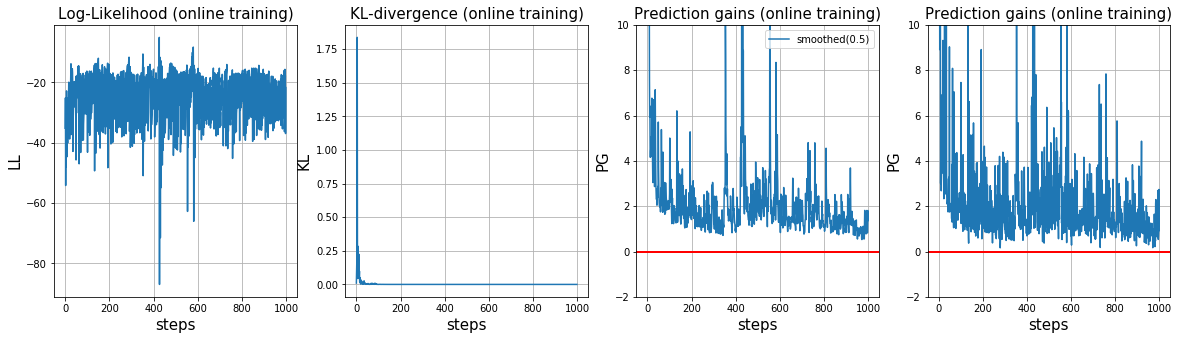

In [11]:
%%time
model = VAE(input_shape=(-1, dim), n_samples=25)
optimizer = optim.RMSprop(model.parameters(), lr=0.0005, momentum=0, weight_decay=1, eps=0.0001)
results = train_online(schedule, X_test,model, optimizer, kl_weight=1, alpha=0.5, img_name=None)

#### Посмотрим, как ведут себя KL и итоговый функционал, когда PG<0.

In [12]:
from collections import defaultdict
n = len(pgs)
cnt = defaultdict(int)

for i in range(n):
    pg_sign = 1 if pgs[i]>=0 else -1
    loss_sign = 1 if total_loss_gains[i]>=0 else -1
    kl_sign = 1 if kl_gains[i] >= 0 else -1
    
    cnt[(pg_sign, loss_sign, kl_sign)] += 1

In [13]:
# Loss = -1*LL + KLD

#(-1,-1,-1) - LL уменьш, Loss уменьш, KL уменьш => -1*LL увел меньше, чем KL уменьш - ОК - НОРМА ДЛЯ МОДЕЛИ(159).
#(-1,-1,1) - LL уменьш, Loss уменьш, KL увел => -1*LL увел, KL увел - не ОК -------------------------------.

#(-1,1,-1) - LL уменьш, Loss увел, KL уменьш => -1*LL увел, KL уменьш - ОК -  НОРМА ДЛЯ МОДЕЛИ (135).
#(-1,1, 1) - LL уменьш, Loss увел, KL увел => -1*LL увел, KL увел - ОК НЕ НОРМА ДЛЯ МОДЕЛИ (28).

#(1,-1,-1) - LL увел, Loss уменьш, KL уменьш - ОК (260)
#(1,-1,1) -  LL увел, Loss уменьш, KL увел - ОК (388)

#(1,1,-1) - LL увел, Loss увел, KL уменьш - не ОК------------
#(1,1,1) - LL увел, Loss увел, KL увел - ОК (30)

In [14]:
total_neg_pct = (cnt[(-1,1,1)]+cnt[(-1,1,-1)]+cnt[(-1,-1,-1)])/num_steps
good_neg_pct = (cnt[(-1,-1,-1)] + cnt[(-1, 1, -1)])/num_steps
bad_neg_pct = cnt[(-1,1,1)]/num_steps

In [15]:
print(total_neg_pct, good_neg_pct,  bad_neg_pct)

0.269 0.197 0.072


In [16]:
def count_neg_pct(pgs, total_loss_gains, kl_gains):
    n = len(pgs)
    cnt = defaultdict(int)

    for i in range(n):
        pg_sign = 1 if pgs[i]>=0 else -1
        loss_sign = 1 if total_loss_gains[i]>=0 else -1
        kl_sign = 1 if kl_gains[i] >= 0 else -1

        cnt[(pg_sign, loss_sign, kl_sign)] += 1
        
    total_neg_pct = (cnt[(-1,1,1)]+cnt[(-1,1,-1)]+cnt[(-1,-1,-1)])/num_steps
    good_neg_pct = (cnt[(-1,-1,-1)] + cnt[(-1, 1, -1)])/num_steps
    bad_neg_pct = cnt[(-1,1,1)]/num_steps
    
    return total_neg_pct, good_neg_pct,  bad_neg_pct

#### Сделаем перебор весов перед KL дивергенции в оптимизируемом функционале

In [76]:
kl_weights = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

In [80]:
%%time

kl_weights_history =[]
for i,w in enumerate(kl_weights):
    model = VAE(input_shape=(-1, dim), n_samples=1000)
    optimizer = optim.RMSprop(model.parameters(), lr=5*1e-5, momentum=0.5)
    results = train_online(schedule, X_test,model, optimizer, kl_weight=w, img_name='kl_{}.jpg'.format(i+1))
    mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results
    
    total_neg_pct, good_neg_pct,  bad_neg_pct = count_neg_pct(pgs, total_loss_gains, kl_gains)
    
    kl_weights_history.append(( mean_last_ll,  total_neg_pct, good_neg_pct,  bad_neg_pct ))

    print('w={}, LL={:.2f}, pct={:.2f}, good_pct={:.2f}, bad_pct={:.2f}'.format(w,mean_last_ll, \
                                                                                 total_neg_pct, good_neg_pct,\
                                                                                 bad_neg_pct))

w=0, LL=-0.00, pct=0.03, good_pct=0.00, bad_pct=0.03
w=1e-06, LL=-0.00, pct=0.05, good_pct=0.00, bad_pct=0.05
w=1e-05, LL=-0.00, pct=0.05, good_pct=0.00, bad_pct=0.05
w=0.0001, LL=-0.00, pct=0.03, good_pct=0.00, bad_pct=0.03
w=0.001, LL=-0.00, pct=0.06, good_pct=0.04, bad_pct=0.02
w=0.01, LL=-0.01, pct=0.16, good_pct=0.14, bad_pct=0.02
w=0.1, LL=-0.04, pct=0.21, good_pct=0.19, bad_pct=0.02
w=1, LL=-0.39, pct=0.15, good_pct=0.14, bad_pct=0.02
w=10, LL=-8.52, pct=0.10, good_pct=0.09, bad_pct=0.01
CPU times: user 1h 8min 1s, sys: 1min 2s, total: 1h 9min 3s
Wall time: 32min 2s


In [88]:
good_pct = []
bad_pct = []
lls = []
for t in kl_weights_history:
    good_pct.append(t[2])
    bad_pct.append(t[3])
    lls.append(t[0])

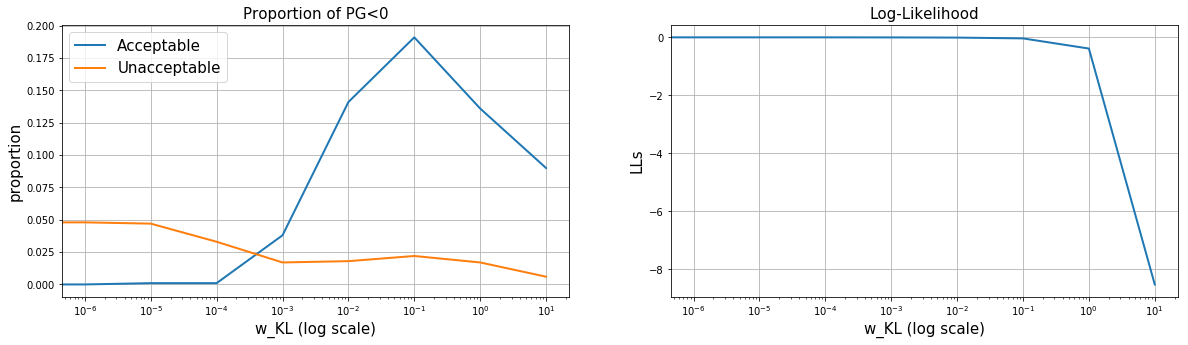

In [91]:

plt.figure(figsize=(20,5))
ax=plt.subplot(121)
plt.plot(kl_weights, good_pct, linewidth=2, label='Acceptable')
plt.plot(kl_weights, bad_pct,  linewidth=2,  label='Unacceptable')
plt.grid()
plt.legend(loc='upper left', fontsize=15)
ax.set_xscale("log", nonposx='clip')
plt.xlabel('w_KL (log scale)', fontsize=15)
plt.ylabel('proportion', fontsize=15)
plt.title('Proportion of PG<0', fontsize=15)

ax=plt.subplot(122)
plt.plot(kl_weights, lls, linewidth=2, label='LLs')
plt.grid()
ax.set_xscale("log", nonposx='clip')
plt.xlabel('w_KL (log scale)', fontsize=15)
plt.ylabel('LLs', fontsize=15)
plt.title('Log-Likelihood', fontsize=15)


In [ ]:
# поочередная оптимизация: сначала KL, потом LL

## Счетчики

In [12]:
from helpers.plots import plot_smoothed_pgs, plot_pseudo_counters_with_alpha_and_degree, plot_counters
from helpers.get_pseudo_counters import get_counters, get_pseudo_count

In [13]:
def smooth(arr, alpha):
    smothed = []
    for i, x in enumerate(arr):
        if i == 0:
            smothed.append(x)
        else:
            smothed.append((1-alpha)*smothed[-1] + alpha*x)
    return np.array(smothed)

#### Зависимость Pseudo-Count on PG

(0, 10)

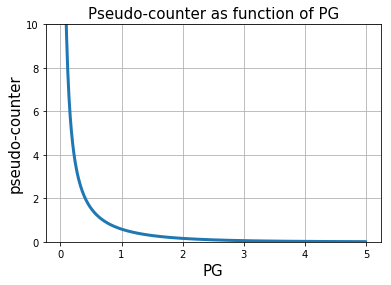

In [14]:
pg_arange = np.arange(0.01, 5, 0.01)
pseudo_cnt = [get_pseudo_count(i) for i in pg_arange]

plt.plot(pg_arange, pseudo_cnt, linewidth=3)
plt.grid()
plt.xlabel('PG', fontsize=15)
plt.ylabel('pseudo-counter', fontsize=15)
plt.title('Pseudo-counter as function of PG', fontsize=15)
plt.ylim((0,10))

#### Pseudo-counter для PG_n = 1/n

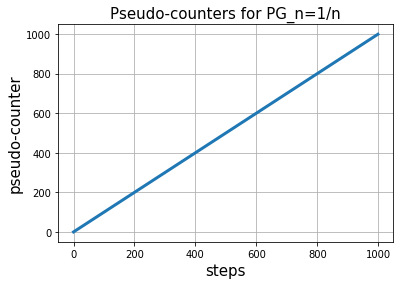

In [15]:
pg_arange = 1 / (1+np.arange(1000))
pseudo_cnt = [get_pseudo_count(i) for i in pg_arange]

plt.plot(pseudo_cnt, linewidth=3)
plt.grid()
plt.ylabel('pseudo-counter', fontsize=15)
plt.xlabel('steps', fontsize=15)
plt.title('Pseudo-counters for PG_n=1/n', fontsize=15)

### W_KL=0 и равномерное поступление объектов 5 классов

CPU times: user 1min 33s, sys: 276 ms, total: 1min 33s
Wall time: 35.9 s


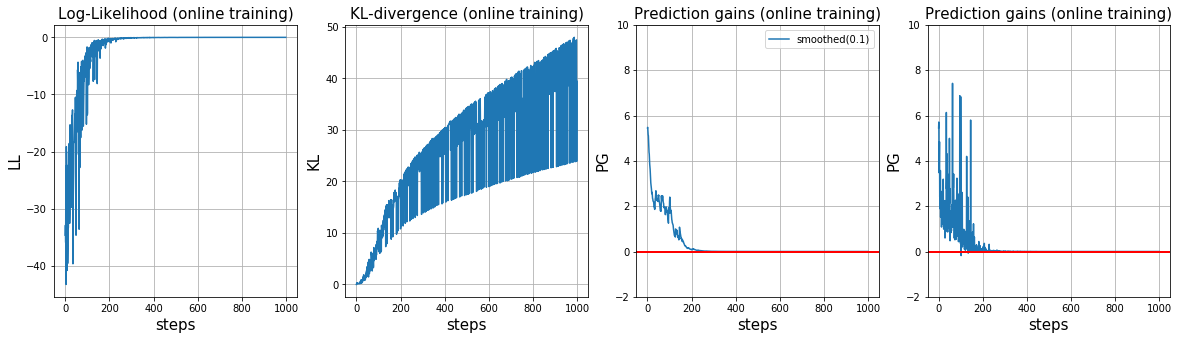

In [16]:
%%time

model = VAE(input_shape=(-1, dim), n_samples=100)
optimizer = optim.RMSprop(model.parameters(), lr=5*1e-5, momentum=0.5)
results = train_online(schedule, X_test,model, optimizer, kl_weight=0)

In [17]:
mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results

In [18]:
real_counters, pseudo_counters, pgs_by_classes = get_counters(schedule, pgs, num_classes)

In [19]:
real_counters.shape

(5, 1001)

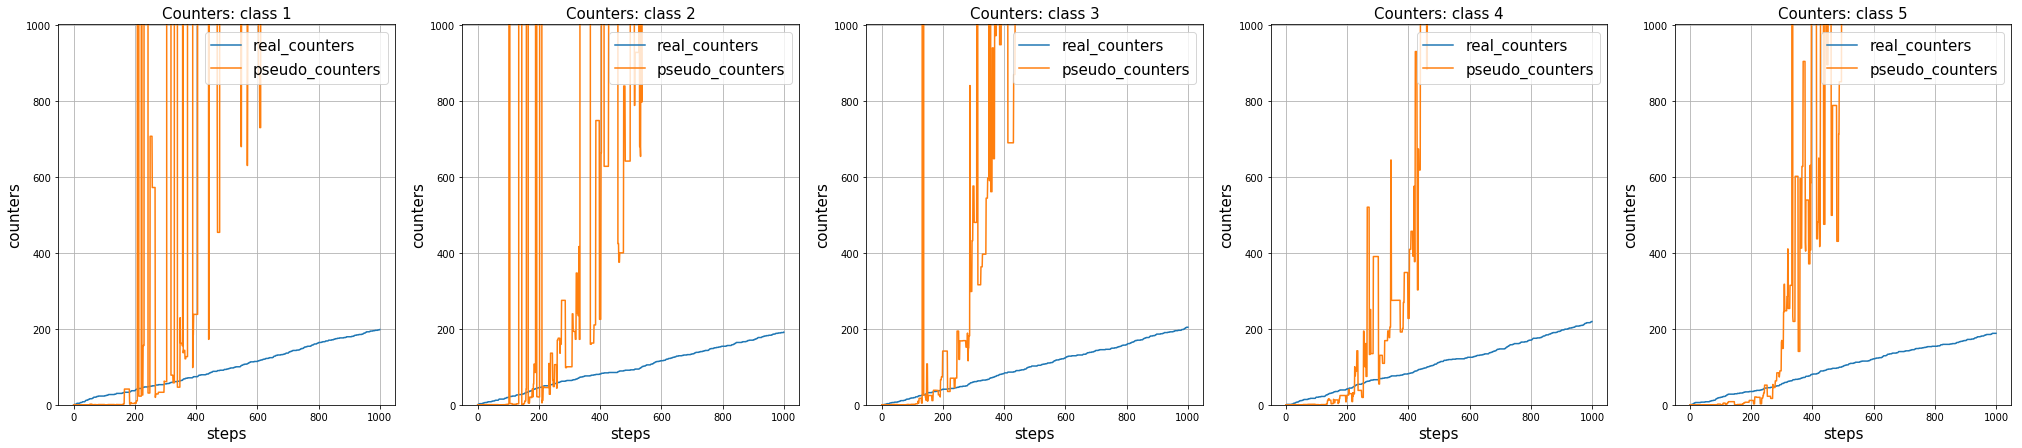

In [21]:
plot_counters(real_counters, pseudo_counters)

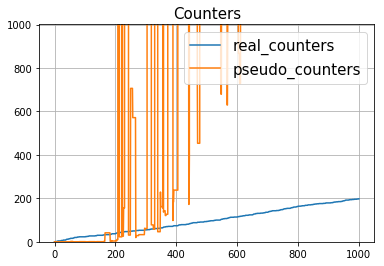

In [22]:
plot_counters(real_counters[0], pseudo_counters[0])

#### Сглаженный PG

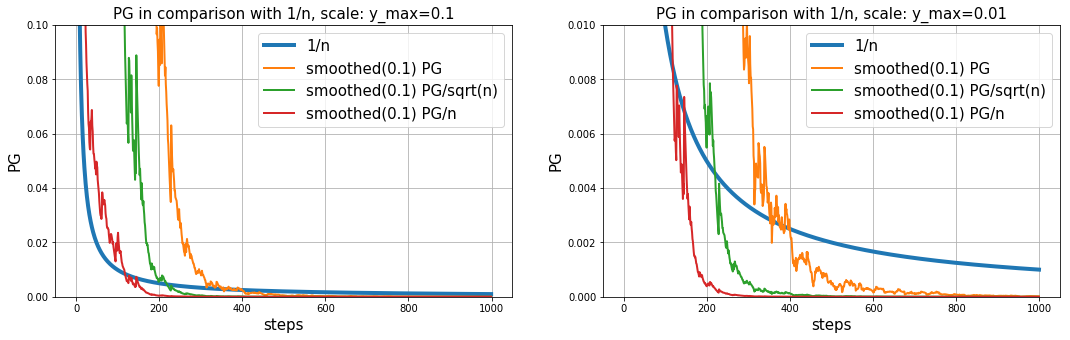

In [23]:
plot_smoothed_pgs(pgs, img_name=None)

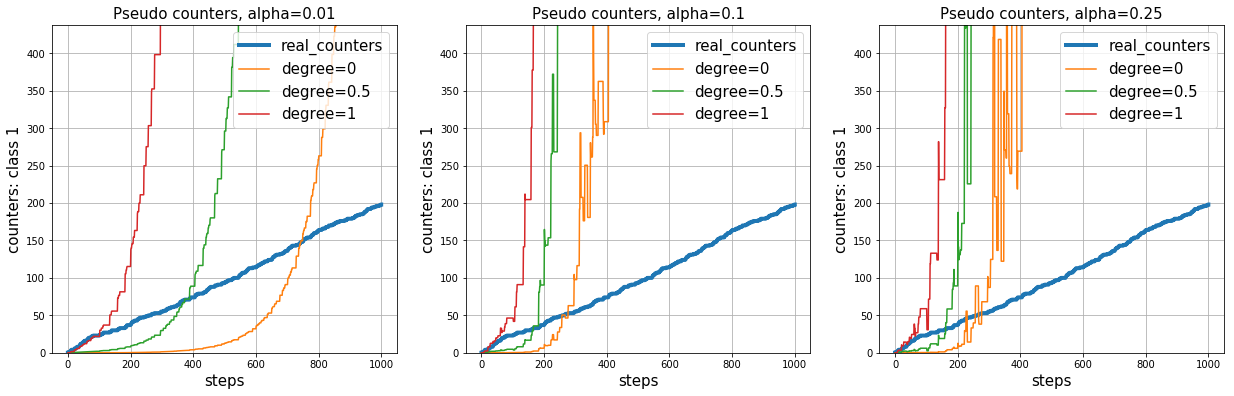

In [24]:
plot_pseudo_counters_with_alpha_and_degree(pgs, schedule, num_classes,
                                           num_classes_to_plot=1,
                                               alpha_range=[0.01, 0.1, 0.25],
                                               degree_range=[0, 0.5, 1],
                                               )
    

In [ ]:
# построить как ведут себя эти псевдо-счетчики

In [ ]:
# как коэф сглаживания влияет на важный всплеск в PG

In [ ]:
# записать историю агента в Q-обучении в качестве нестационарного набора данных

## w_KL=1 и равномерное поступление объектов

CPU times: user 1min 33s, sys: 368 ms, total: 1min 34s
Wall time: 36.1 s


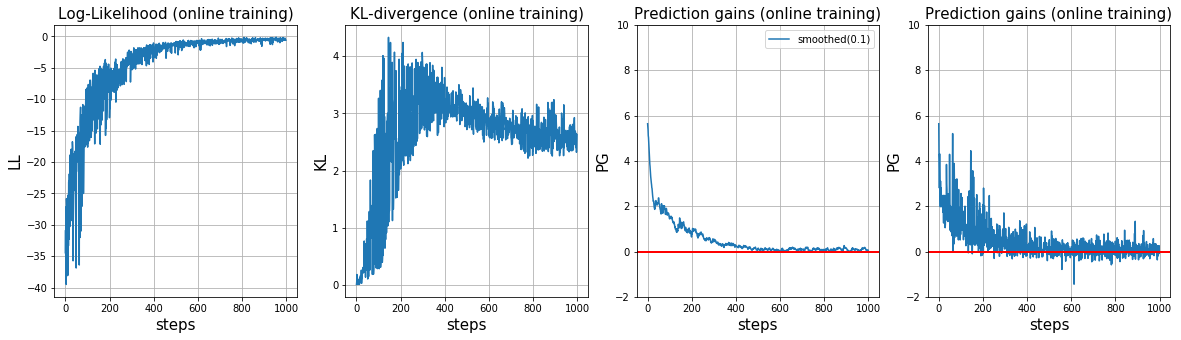

In [25]:
%%time

model = VAE(input_shape=(-1, dim), n_samples=100)
optimizer = optim.RMSprop(model.parameters(), lr=5*1e-5, momentum=0)
results = train_online(schedule, X_test,model, optimizer, kl_weight=1)

In [26]:
mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results

In [27]:
real_counters, pseudo_counters, pgs_by_classes = get_counters(schedule, pgs, num_classes)

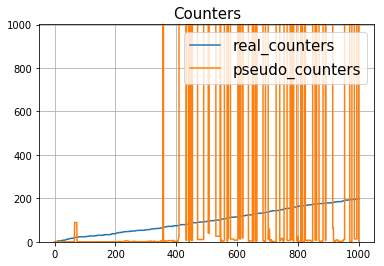

In [28]:
plot_counters(real_counters[0], pseudo_counters[0])

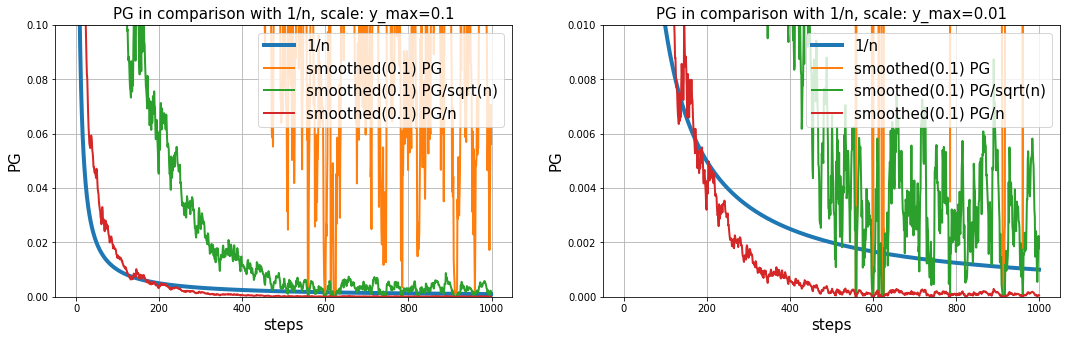

In [29]:
plot_smoothed_pgs(pgs)

In [ ]:
# рисовать не на одном графике, а графики вида f_1/f_2

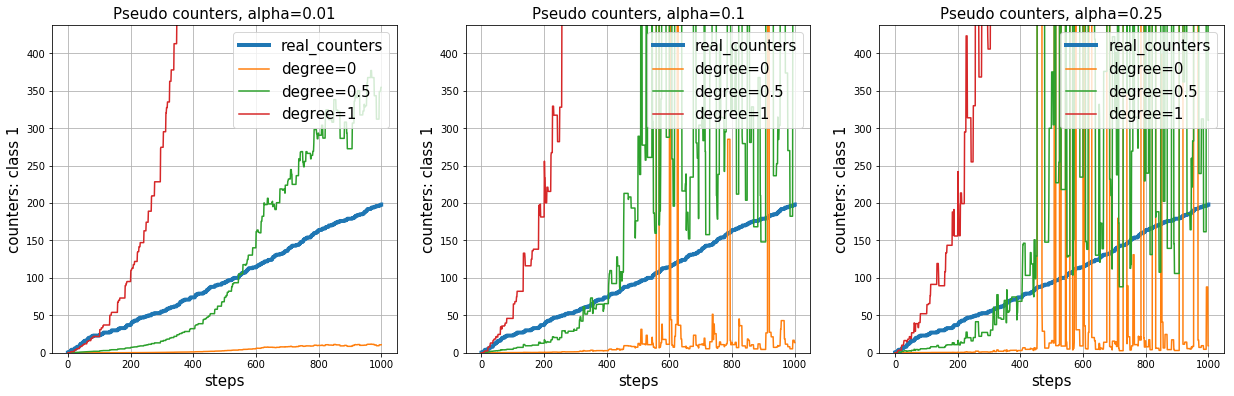

In [31]:
plot_pseudo_counters_with_alpha_and_degree(pgs, schedule, num_classes,
                                           num_classes_to_plot=1,
                                           alpha_range=[0.01, 0.1, 0.25],
                                           degree_range=[0, 0.5, 1],
                                           )

## Чередование 50/50 объектов 2 классов и w_KL=1

CPU times: user 2min 25s, sys: 460 ms, total: 2min 26s
Wall time: 56.6 s


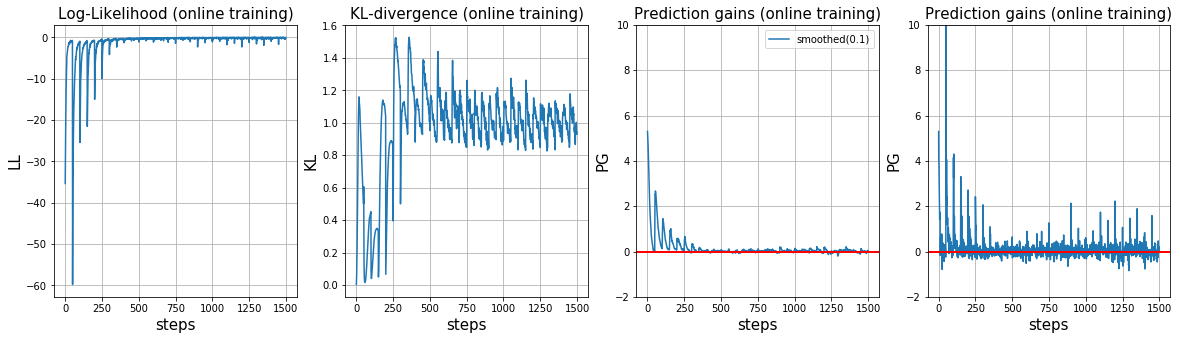

In [55]:
%%time
schedule_1 = ([0 for _ in range(50)] + [1 for _ in range(50)]) * 15
model = VAE(input_shape=(-1, dim), n_samples=100)
optimizer = optim.RMSprop(model.parameters(), lr=5*1e-5, momentum=0)
results = train_online(schedule_1, X_test,model, optimizer, kl_weight=1)

In [56]:
mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results

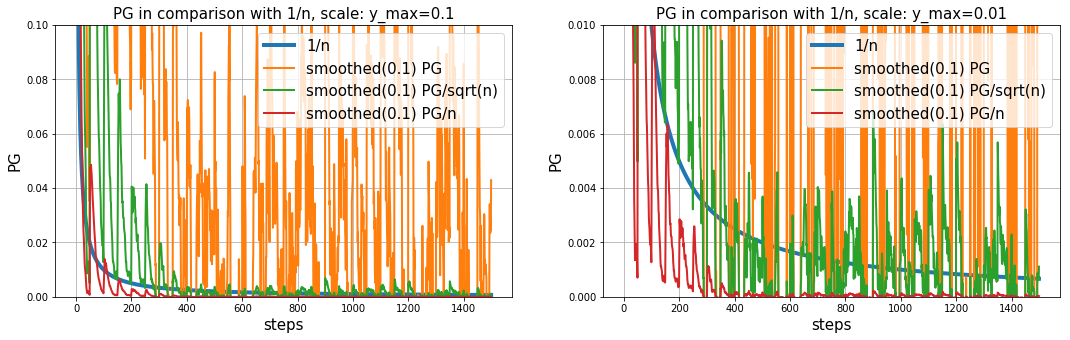

In [57]:
plot_smoothed_pgs(pgs)

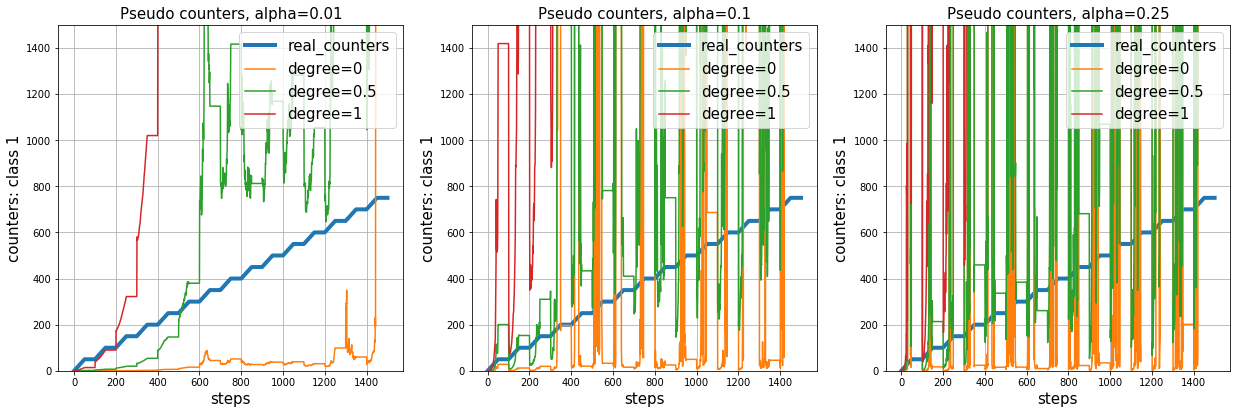

In [59]:
plot_pseudo_counters_with_alpha_and_degree(pgs, schedule_1, 2,
                                           num_classes_to_plot=1,
                                           alpha_range=[0.01, 0.1, 0.25],
                                           degree_range=[0, 0.5, 1],
                                           )

## Чередование 50/50 объектов 2 классов и w_KL=1e-4

CPU times: user 2min 30s, sys: 628 ms, total: 2min 30s
Wall time: 59.1 s


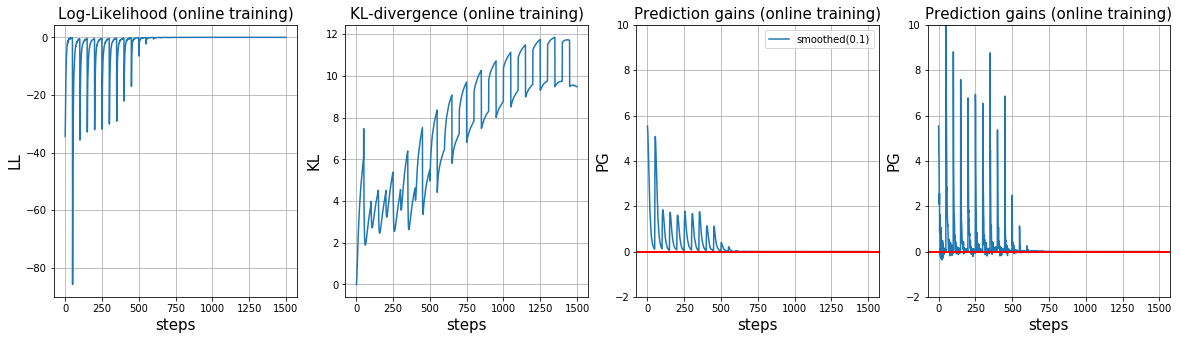

In [61]:
%%time
schedule_1 = ([0 for _ in range(50)] + [1 for _ in range(50)]) * 15
model = VAE(input_shape=(-1, dim), n_samples=100)
optimizer = optim.RMSprop(model.parameters(), lr=5*1e-5, momentum=0)
results = train_online(schedule_1, X_test,model, optimizer, kl_weight=1e-4)

In [62]:
mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results

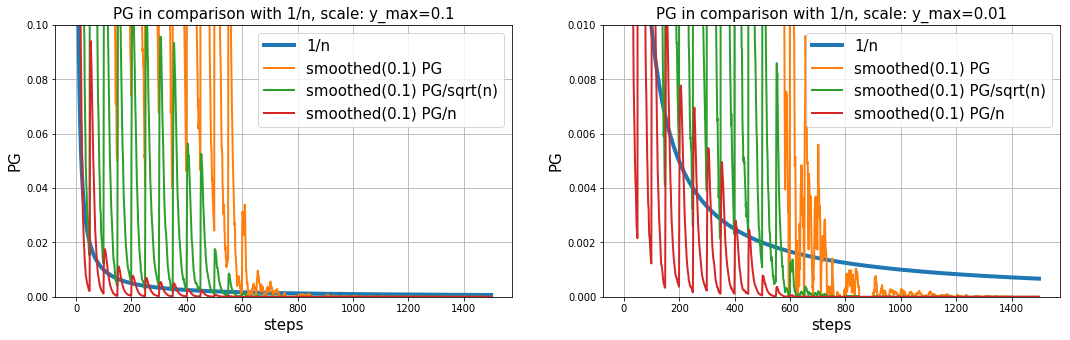

In [63]:
plot_smoothed_pgs(pgs)

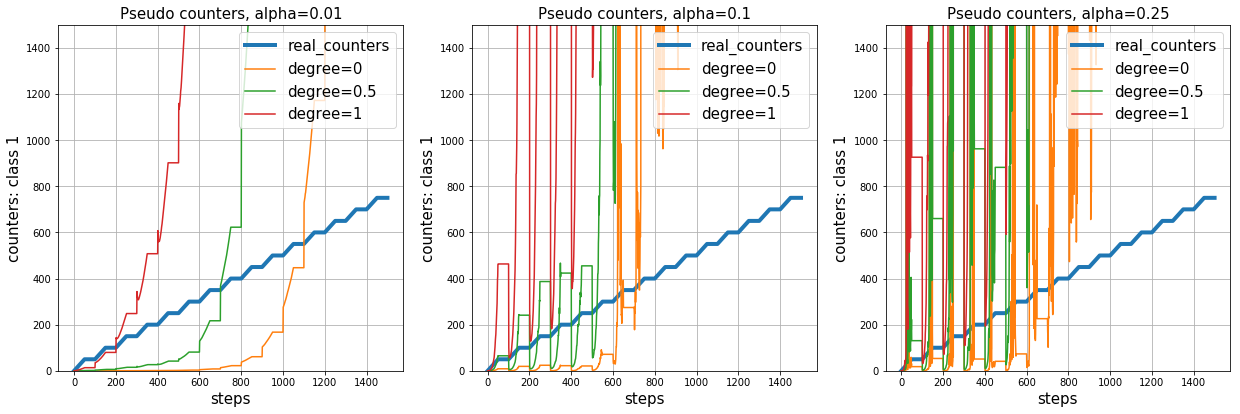

In [64]:
plot_pseudo_counters_with_alpha_and_degree(pgs, schedule_1, 2,
                                           num_classes_to_plot=1,
                                           alpha_range=[0.01, 0.1, 0.25],
                                           degree_range=[0, 0.5, 1],
                                           )

CPU times: user 3min 36s, sys: 900 ms, total: 3min 36s
Wall time: 1min 26s


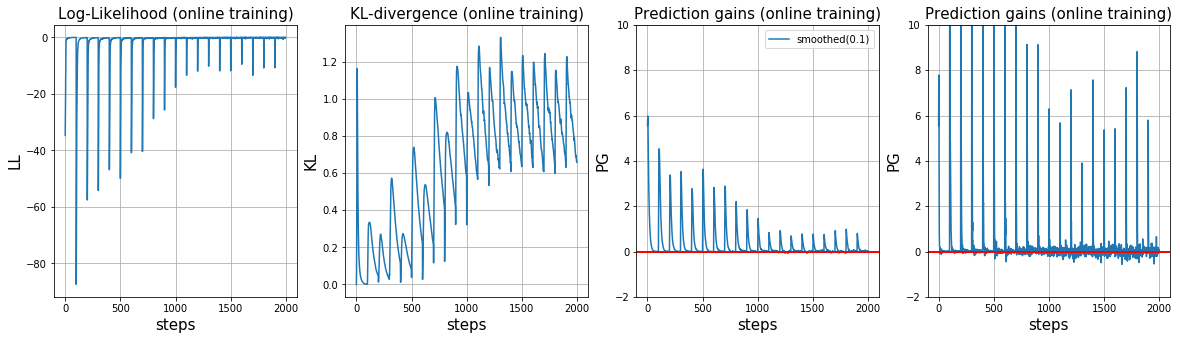

In [65]:
%%time
schedule_2 = ([0 for _ in range(100)] + [1 for _ in range(100)]) * 10
model = VAE(input_shape=(-1, dim), n_samples=100)
optimizer = optim.RMSprop(model.parameters(), lr=5*1e-5, momentum=0.5)
results = train_online(schedule_2, X_test,model, optimizer, kl_weight=1)

In [66]:
mean_last_ll, pct, all_log_probs, pgs, total_loss_gains, kl_gains = results

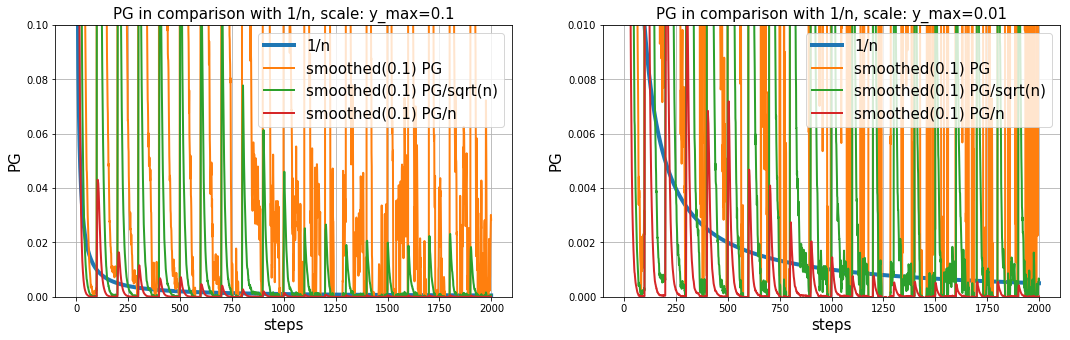

In [67]:
plot_smoothed_pgs(pgs)

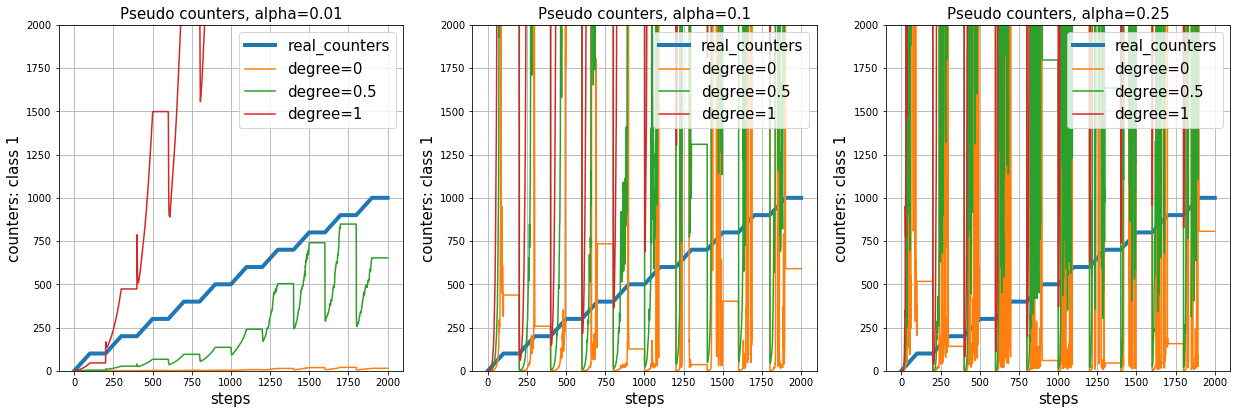

In [68]:
plot_pseudo_counters_with_alpha_and_degree(pgs, schedule_2, 2,
                                           num_classes_to_plot=1,
                                           alpha_range=[0.01, 0.1, 0.25],
                                           degree_range=[0, 0.5, 1],
                                           )